# (Step 5) Deciding on and implementing the “best" CNN model

We created an image dataset with Bing (see [Colab: (Step 3) - Creation of image data set: Bing image download](https://colab.research.google.com/drive/11VHklqR_TRG6QjMEuKsr6ROsesNUqGnP?usp=sharing), [Github](https://github.com/TechLabs-Berlin/st22-active-learn-trees/blob/main/DL-neural-network/Step3-tree-images-dataset/(Step_3)_Creation_of_image_data_set_Bing_image_download.ipynb) ).

The two test images that can be found here: [Image_2.jpeg](
https://github.com/TechLabs-Berlin/st22-active-learn-trees/blob/main/DL-neural-network/Step1-exploring-datasets/Image_2.jpeg)
[hornbeam-1.jpeg](
https://github.com/TechLabs-Berlin/st22-active-learn-trees/blob/main/DL-neural-network/Step1-exploring-datasets/hornbeam-1.jpeg)




#### Download image dataset

In [1]:
!curl -O https://zenodo.org/record/4446955/files/Leaves.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  135M  100  135M    0     0  15.4M      0  0:00:08  0:00:08 --:--:-- 23.2M


In [2]:
!unzip -q Leaves.zip
!ls

Leaves	Leaves.zip  sample_data


In [3]:
!ls Leaves

 Ash   Beech   Hornbeam  'Mountain oak'  'Sycamore maple'


In [4]:
species = ['Ash' ,  'Beech'  , 'Hornbeam' , 'Mountain oak' , 'Sycamore maple']

In [5]:
len(species)

5

### Setup

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



## Model building for Bing leaves dataset

In [7]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": species
}

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    "Leaves",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "Leaves",
  subset="validation",
    **args
)

Found 122 files belonging to 5 classes.
Using 98 files for training.
Found 122 files belonging to 5 classes.
Using 24 files for validation.


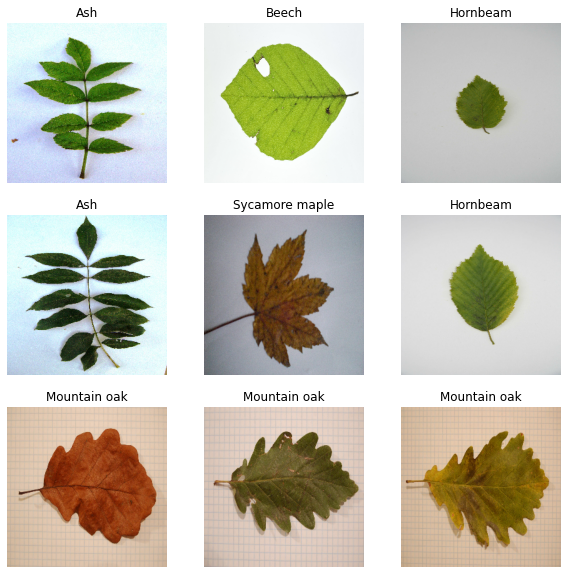

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        f = np.argmax(labels[i])
        plt.title(species[f])
        plt.axis("off")

### autotune images

In [10]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Training

In [12]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(
        optimizer='adam', # how to predict error/ tries to minimize error 
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )
    
    ## alternative Model compiling
    #model.compile(
    #    optimizer='rmsprop',
    #    loss='binary_crossentropy',
    #    metrics=['accuracy']
    #    )

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

#### First model

In [ ]:
network_1 = Sequential([
  tf.keras.layers.Rescaling(1./255), # rescale input layer
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)), # scan over image and generate new features
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(species))
])

In [ ]:
history_df, model = train_model(network_1)

Epoch 1/5
4/4 [==============================] - 14s 338ms/step - loss: 127.5747 - accuracy: 0.2041 - val_loss: 108.3759 - val_accuracy: 0.2500
Epoch 2/5
4/4 [==============================] - 0s 58ms/step - loss: 96.3648 - accuracy: 0.2245 - val_loss: 34.5924 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 0s 56ms/step - loss: 28.8026 - accuracy: 0.4898 - val_loss: 15.5198 - val_accuracy: 0.4167
Epoch 4/5
4/4 [==============================] - 0s 56ms/step - loss: 12.5711 - accuracy: 0.5408 - val_loss: 3.7412 - val_accuracy: 0.7917
Epoch 5/5
4/4 [==============================] - 0s 57ms/step - loss: 9.1396 - accuracy: 0.5306 - val_loss: 0.9570 - val_accuracy: 0.8333


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 5)                 134218949 
                                                                 
Total params: 134,218,949
Trainable params: 134,218,949
Non-trainable params: 0
_________________________________________________________________


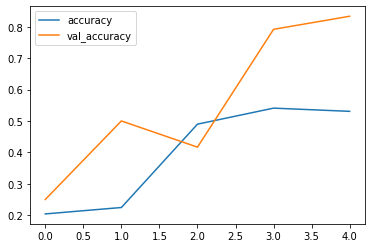

In [ ]:
history_df[["accuracy", "val_accuracy"]].plot()

**Model 1 Sequential CNN** with relu activation  trained for 5 Epochs

**Epoch 1:**
- accuracy: 0.2041 
- val_accuracy: 0.2500

**Epoch 5:**
- accuracy: 0.5306 
- val_accuracy: 0.8333

#### Second model

In [ ]:
network_2 = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(species))
]

history_df, model = train_model(network_2)

Epoch 1/5
4/4 [==============================] - 2s 181ms/step - loss: 5.7275 - accuracy: 0.1531 - val_loss: 2.1248 - val_accuracy: 0.2500
Epoch 2/5
4/4 [==============================] - 0s 51ms/step - loss: 1.7298 - accuracy: 0.2653 - val_loss: 1.5972 - val_accuracy: 0.0833
Epoch 3/5
4/4 [==============================] - 0s 52ms/step - loss: 1.4896 - accuracy: 0.2245 - val_loss: 1.3417 - val_accuracy: 0.6667
Epoch 4/5
4/4 [==============================] - 0s 51ms/step - loss: 1.2802 - accuracy: 0.5204 - val_loss: 0.9166 - val_accuracy: 0.7917
Epoch 5/5
4/4 [==============================] - 0s 51ms/step - loss: 0.8310 - accuracy: 0.7653 - val_loss: 0.5505 - val_accuracy: 0.6667


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)       

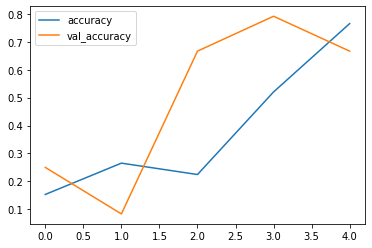

In [ ]:
history_df[["accuracy", "val_accuracy"]].plot()

**Model 2 Sequential CNN with MaxPooling2D** trained for 5 Epochs

**Epoch 1:**
- accuracy: 0.1531
- val_accuracy: 0.2500

**Epoch 5:**
- accuracy: 0.7653  
- val_accuracy: 0.6667

#### Model 3: Second Model with Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)

full_network = [
    data_augmentation
] + network_2

history_df, model = train_model(full_network, epochs=10)

Epoch 1/10
4/4 [==============================] - 2s 105ms/step - loss: 2.0048 - accuracy: 0.4286 - val_loss: 1.0159 - val_accuracy: 0.6667
Epoch 2/10
4/4 [==============================] - 0s 56ms/step - loss: 1.1673 - accuracy: 0.6939 - val_loss: 0.7428 - val_accuracy: 0.6250
Epoch 3/10
4/4 [==============================] - 0s 54ms/step - loss: 1.1613 - accuracy: 0.5204 - val_loss: 0.5542 - val_accuracy: 0.9583
Epoch 4/10
4/4 [==============================] - 0s 56ms/step - loss: 0.9028 - accuracy: 0.7551 - val_loss: 0.3095 - val_accuracy: 0.9167
Epoch 5/10
4/4 [==============================] - 0s 54ms/step - loss: 0.6250 - accuracy: 0.7347 - val_loss: 0.1826 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 53ms/step - loss: 0.5240 - accuracy: 0.7551 - val_loss: 0.1290 - val_accuracy: 0.9583
Epoch 7/10
4/4 [==============================] - 0s 58ms/step - loss: 0.3165 - accuracy: 0.8878 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 8/10
4/4 [==========

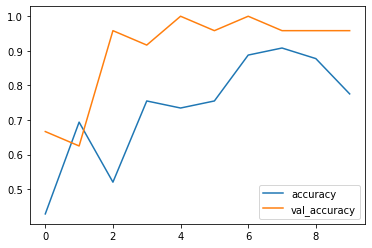

In [ ]:
history_df[["accuracy", "val_accuracy"]].plot()

**Model 3 Sequential CNN with MaxPooling2D and data augmentation** trained for 10 Epochs

**Epoch 1:**
- accuracy: 0.4286 
- val_accuracy: 0.6667

**Epoch 5:**
- accuracy: 0.7347  
- val_accuracy: 1.0000

**Epoch 10:**
- accuracy: 0.7755 
- val_accuracy: 0.9583

In [ ]:
model.save('model.h5')

### Pretraines model using [inaturalist](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5)-- Model 4--- 

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### using .map 

normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


#### Prefetching : to Shorten the training time 

(enhancing ideas for later: using interleave for better performance [interlaeve in keras](https://www.tensorflow.org/guide/data_performance)

In [14]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### model trainning

In [15]:
from IPython.display import clear_output, Image, display, HTML
import tensorflow_hub as hub

In [19]:
### settup the NN 

network_4 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5",
                   trainable=False),  # Can be True, see below. trainable=True, arguments=dict(batch_norm_momentum=0.997))
    tf.keras.layers.Dense(5, activation='softmax')
])

network_4.build([None, 299, 299, 3])

In [23]:
### training the model 

history_df, model = train_model(network_4, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 3s 345ms/step - loss: 0.9257 - accuracy: 0.8265 - val_loss: 4.7785 - val_accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 0s 89ms/step - loss: 1.2795 - accuracy: 0.7653 - val_loss: 0.8217 - val_accuracy: 0.8750
Epoch 3/10
4/4 [==============================] - 0s 92ms/step - loss: 0.3846 - accuracy: 0.8980 - val_loss: 0.5008 - val_accuracy: 0.9167
Epoch 4/10
4/4 [==============================] - 0s 90ms/step - loss: 0.1141 - accuracy: 0.9796 - val_loss: 0.9980 - val_accuracy: 0.8333
Epoch 5/10
4/4 [==============================] - 0s 90ms/step - loss: 0.4801 - accuracy: 0.8571 - val_loss: 1.1716 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 0s 91ms/step - loss: 0.0810 - accuracy: 0.9694 - val_loss: 0.8678 - val_accuracy: 0.8333
Epoch 7/10
4/4 [==============================] - 0s 93ms/step - loss: 0.0403 - accuracy: 0.9898 - val_loss: 0.9830 - val_accuracy: 0.8333
Epoch 8/10
4/4 [=====================

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 5)                 21813029  
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


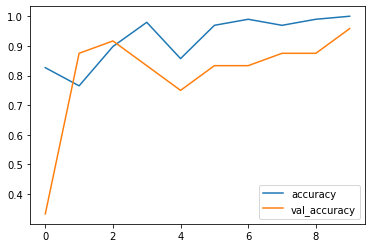

In [25]:
history_df[["accuracy", "val_accuracy"]].plot()

**Model 4 inaturalist pretrained model ** trained for 10 Epochs

**Epoch 1:**
- accuracy:  0.8265
- val_accuracy: 0.3333

**Epoch 5:**
- accuracy: 0.8571
- val_accuracy: 0.7500

**Epoch 10:**
- accuracy: 1.0000 
- val_accuracy: 0.9583

In [26]:
model.save('model.h6')

INFO:tensorflow:Assets written to: model.h6/assets


INFO:tensorflow:Assets written to: model.h6/assets


## Choosing between model 3 and model 4 
it was a tough desicion to use either model 3 or model 4.so we decided to campare each one and in terms of ability to predict 

- the results proved that Model 3 & Model 4 are nearly the same in predction results, so we chooose **model 3** as an implementation model 

### Evaluate results from model 4 on test set

In [27]:
from keras.models import load_model
model = load_model('model.h6')

In [28]:
preds = model.predict(test)

In [29]:
from PIL import Image
#
import numpy as np
predicted_class = np.argmax(preds, axis=1)
predicted_class

#
actual_labels = np.concatenate([y for x, y in test], axis=0)

#
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

#
actual_class = np.argmax(actual_labels, axis=1)

#
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

#
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: species[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: species[x])


[Text(0, 0.5, 'Ash'),
 Text(0, 1.5, 'Beech'),
 Text(0, 2.5, 'Hornbeam'),
 Text(0, 3.5, 'Mountain oak'),
 Text(0, 4.5, 'Sycamore maple')]

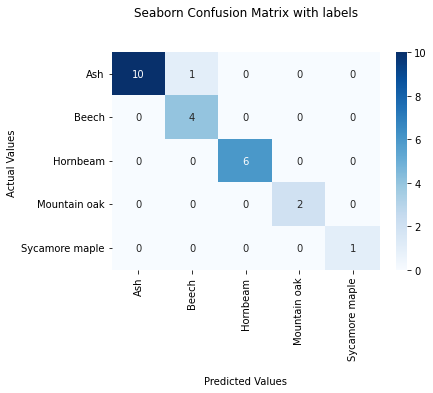

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(pred_df['prediction'], pred_df['actual'])

#print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(species, rotation=90)
ax.yaxis.set_ticklabels(species, rotation=0)

Incorrect identification of Sycamore maple.

,prediction,actual,image
0,Ash,Ash,
1,Ash,Ash,
2,Ash,Ash,
3,Beech,Beech,
4,Hornbeam,Hornbeam,

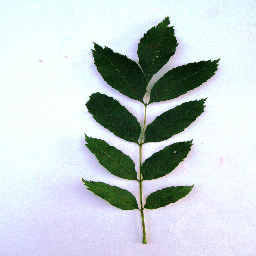
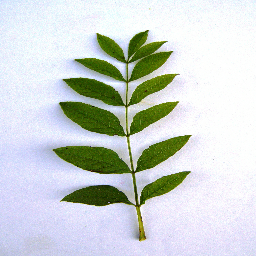
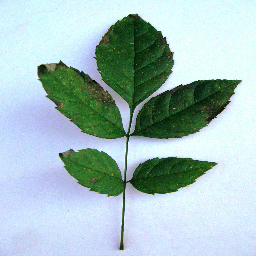
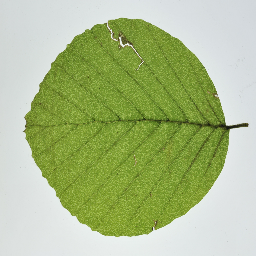
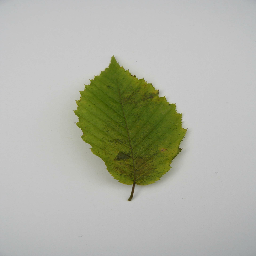

In [31]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head(5).style.format({'image': image_formatter})

### Model 4 Predict single image

In [32]:
from keras.models import load_model

# load the model we saved
model = load_model('model.h6')

from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 256, 256

In [33]:
# predicting images
def predict_image(image_path, img_width, img_height, model, list_of_classes):
  img = image.load_img(image_path, target_size=(img_width, img_height))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes, axis=1)
  return list_of_classes[predicted_class[0]]

In [34]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def image_show(image_path):
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


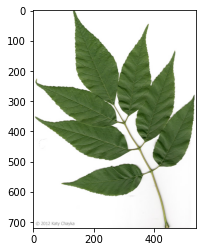

'Ash'

In [47]:
image_path = "/content/gdrive/MyDrive/test imges /ash 2.jpg"
image_show(image_path)
predict_image(image_path, img_width, img_height, model, species)

incorrect identification of the Ash image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

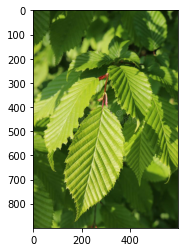

'Mountain oak'

In [45]:
image_path = '/content/gdrive/MyDrive/test imges /hornbeam-tree-leaves-close-up-fresh-hornbeam-carpinus-betulus-tree-leaves-shining-sunlight-blurred-background-126694799.jpg'
image_show(image_path)
predict_image(image_path, img_width, img_height, model, species)

Incorect identifcation (Predicted Mountain Oak instead of Hornbeam).

### Evaluate results from model 3 on test set

In [ ]:
from keras.models import load_model
model = load_model('model.h5')

In [ ]:
preds = model.predict(test)

In [ ]:
from PIL import Image
#
import numpy as np
predicted_class = np.argmax(preds, axis=1)
predicted_class

#
actual_labels = np.concatenate([y for x, y in test], axis=0)

#
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

#
actual_class = np.argmax(actual_labels, axis=1)

#
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

#
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: species[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: species[x])


[Text(0, 0.5, 'Ash'),
 Text(0, 1.5, 'Beech'),
 Text(0, 2.5, 'Hornbeam'),
 Text(0, 3.5, 'Mountain oak'),
 Text(0, 4.5, 'Sycamore maple')]

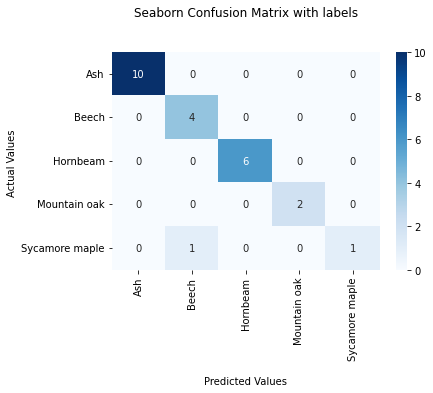

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(pred_df['prediction'], pred_df['actual'])

#print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(species, rotation=90)
ax.yaxis.set_ticklabels(species, rotation=0)

Incorrect identification of Sycamore maple.

,prediction,actual,image
0,Ash,Ash,
1,Ash,Ash,
2,Ash,Ash,
3,Beech,Beech,
4,Hornbeam,Hornbeam,

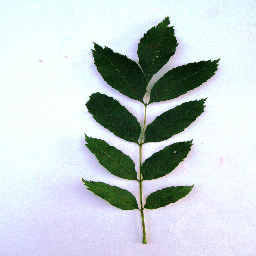
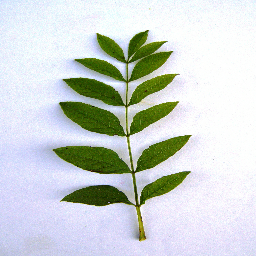
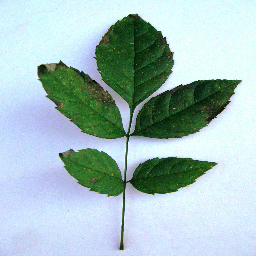
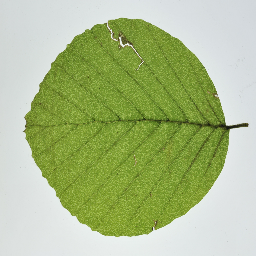
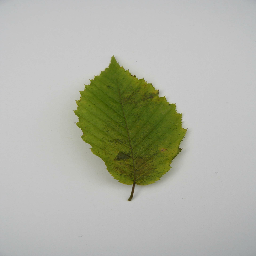

In [ ]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head(5).style.format({'image': image_formatter})

### Model 3 Predict single image

In [ ]:
from keras.models import load_model

# load the model we saved
model = load_model('model.h5')

from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 256, 256
#img_width, img_height = args["image_size"] # alternative way to access information on image size

In [ ]:
# predicting images
def predict_image(image_path, img_width, img_height, model, list_of_classes):
  img = image.load_img(image_path, target_size=(img_width, img_height))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes, axis=1)
  return list_of_classes[predicted_class[0]]

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def image_show(image_path):
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


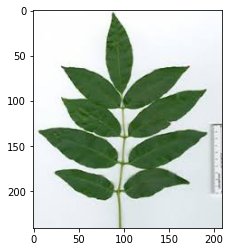

'Ash'

In [ ]:
image_path = '/content/Image_2.jpeg'
image_show(image_path)
predict_image(image_path, img_width, img_height, model, species)

Correct identification of the Ash image.

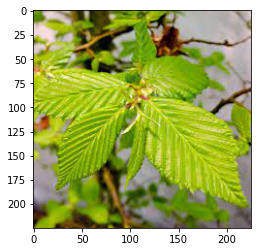

'Mountain oak'

In [ ]:
image_path = '/content/hornbeam-1.jpeg'
image_show(image_path)
predict_image(image_path, img_width, img_height, model, species)

Incorect identifcation (Predicted Mountain Oak instead of Hornbeam).

# Pretraines model using Fast AI (resnet18) -- model 5--

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 7.2 MB/s 
     |████████████████████████████████| 365 kB 64.2 MB/s 
     |████████████████████████████████| 4.7 MB 16.5 MB/s 
     |████████████████████████████████| 1.2 MB 34.8 MB/s 
     |████████████████████████████████| 212 kB 76.3 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 141 kB 76.0 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
     |████████████████████████████████| 127 kB 59.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *


Same for trees (unsing "Leaves" dataset)

In [ ]:
tree_types = 'Ash','Beech','Hornbeam', 'Mountain oak', 'Sycamore maple'
path = Path('Leaves')



In [ ]:
# if folder has images: 
fns = get_image_files(path)
fns


###
# corrupt images:
#failed = verify_images(fns)
#failed

###

# To remove all the failed images, you can use unlink on each of them. Note that, 
#like most fastai functions that return a collection, verify_images returns an object of type L, 
#which includes the map method. This calls the passed function on each element of the collection:
#failed.map(Path.unlink);


####

trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

trees = trees.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = trees.dataloaders(path)

learn_trees = cnn_learner(dls, resnet18, metrics=error_rate) # rename cnn_learner to vision_learner
learn_trees.fine_tune(4)



/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.508874,3.272461,0.750000,00:10


epoch,train_loss,valid_loss,error_rate,time
0,2.982796,2.479390,0.750000,00:10
1,2.549793,1.314099,0.458333,00:09
2,1.956277,0.609048,0.208333,00:10
3,1.559169,0.350268,0.125000,00:09


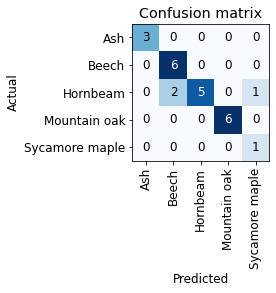

In [ ]:
###

interp = ClassificationInterpretation.from_learner(learn_trees)
interp.plot_confusion_matrix()

#### predict image 

In [ ]:
## Export Data
learn_trees.export()

path = Path()
path.ls(file_exts='.pkl')

learn_inf = load_learner(path/'export.pkl')


In [ ]:
learn_inf.predict('/content/Image_2.jpeg')

('Ash', TensorBase(0), TensorBase([0.9184, 0.0054, 0.0010, 0.0082, 0.0669]))

In [ ]:
learn_inf.predict('/content/hornbeam-1.jpeg')

('Mountain oak',
 TensorBase(3),
 TensorBase([0.0268, 0.0220, 0.0444, 0.7109, 0.1959]))

with a similar results between model 3 , model 4 , and model 5, it is clear that there is coomen confusin between mountain oak and Hornbeam leaves.

- we need to train the model on bigger dataset to have better results